### Qualitative analysis

- What kind of trajectories does VBD generate?
- Can an RL agent correct for unrealistic trajectories?


In [2]:
import importlib
import gpudrive
importlib.reload(gpudrive)

import numpy as np
import os
import torch
import mediapy
import dataclasses
from pathlib import Path
from tqdm import tqdm
# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import madrona_gpudrive

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.datatypes.observation import GlobalEgoState
from gpudrive.datatypes.info import Info

from gpudrive.visualize.utils import img_from_fig
from gpudrive.utils.checkpoint import load_agent

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

### Helper functions

In [ ]:
def rollout(
    env: GPUDriveTorchEnv,
    sim_agent: torch.nn.Module,
    init_steps: int,
    num_envs: int,
    max_agents: int,
    device: str,
    render_simulator_states: bool = False,
    render_agent_pov: bool = False,
    render_every_n_steps: int = 5,
    save_videos: bool = True,
    video_dir: str = "videos",
    video_format: str = "gif",
):
    """Rollout agent in the environment and return the scenario rollouts."""

    if save_videos:
        os.makedirs(video_dir, exist_ok=True)

    # Storage
    env_ids = list(range(num_envs))
    simulator_state_frames = {env_id: [] for env_id in range(num_envs)}
    agent_observation_frames = {env_id: [] for env_id in range(num_envs)}

    _ = env.reset()

    # Zero out actions for parked vehicles
    info = Info.from_tensor(
        env.sim.info_tensor(),
        backend=env.backend,
        device=env.device,
    )
    control_mask_all = env.cont_agent_mask.clone()
    zero_action_mask = (info.off_road == 1) | (
        info.collided_with_vehicle == 1
    ) & (info.type == int(madrona_gpudrive.EntityType.Vehicle))
    control_mask = control_mask_all & ~zero_action_mask

    next_obs = env.reset(control_mask)

    # Get scenario ids
    scenario_ids_dict = env.get_scenario_ids()
    scenario_ids = list(scenario_ids_dict.values())

    pos_x_list = []
    pos_y_list = []
    heading_list = []
    done_list = [env.get_dones()]

    for time_step in range(env.episode_len - init_steps):

        # Predict actions
        action, _, _, _ = sim_agent(next_obs)

        action_template = torch.zeros(
            (num_envs, max_agents), dtype=torch.int64, device=device
        )
        action_template[control_mask] = action.to(device)

        # Step
        env.step_dynamics(action_template)

        # Render
        if render_simulator_states and time_step % render_every_n_steps == 0:
            sim_states = env.vis.plot_simulator_state(
                env_indices=env_ids,
                zoom_radius=100,
                time_steps=[time_step] * len(env_ids),
                plot_guidance_pos_xy=True,
            )
            for idx in range(num_envs):
                simulator_state_frames[idx].append(
                    img_from_fig(sim_states[idx])
                )

        if render_agent_pov and time_step % render_every_n_steps == 0:
            agent_obs = env.vis.plot_agent_observation(
                env_idx=0,
                agent_idx=0,
                figsize=(10, 10),
                trajectory=env.reference_path[0, :, :].to("cpu"),
            )
            agent_observation_frames[idx].append(img_from_fig(agent_obs))

        # Get next observation
        next_obs = env.get_obs(control_mask)
        done = env.get_dones()
        
        states = GlobalEgoState.from_tensor(
            env.sim.absolute_self_observation_tensor(),
            backend=env.backend,
            device=env.device,
        )
        
        pos_xy = states.pos_xy
        heading = states.rotation_angle
        vel_xy = states.vel_xy
        
        pos_x_list.append(pos_xy[:, 0])
        pos_y_list.append(pos_xy[:, 1])
        heading_list.append(heading)
        done_list.append(done)
    _ = done_list.pop()

    if save_videos:
        for idx in range(num_envs):
            scenario_id = scenario_ids_dict[idx]
            if (
                render_simulator_states
                and len(simulator_state_frames[idx]) > 0
            ):
                mediapy.write_video(
                    f"{video_dir}/sim_state_env_{idx}_{scenario_id}.{video_format}",
                    np.array(simulator_state_frames[idx]),
                    fps=8,
                    codec=video_format,
                )

        if render_agent_pov and len(agent_observation_frames[0]) > 0:
            scenario_id = scenario_ids_dict[0]
            mediapy.write_video(
                f"{video_dir}/agent_0_{scenario_id}.{video_format}",
                np.array(agent_observation_frames[0]),
                fps=8,
                codec=video_format,
            )

    # Generate Scenario
    pos_x_stack = torch.stack(pos_x_list, dim=-1).cpu().numpy()
    pos_y_stack = torch.stack(pos_y_list, dim=-1).cpu().numpy()
    heading_stack = torch.stack(heading_list, dim=-1).cpu().numpy()
    done_stack = torch.stack(done_list, dim=-1).cpu().numpy()
    control_mask = control_mask.cpu().numpy()
    
    return pos_x_stack, pos_y_stack, heading_stack, done_stack, control_mask

### Settings

In [4]:
DATA_FOLDER = "data/processed/wosac/validation_json_3"
FIGURES_FOLDER = "examples/eval/figures"

### Make environment

In [5]:
# Settings
MAX_AGENTS = 64
NUM_ENVS = 3
DEVICE = "cpu"  
NUM_ROLLOUTS = 1
INIT_STEPS = 0
DATASET_SIZE = 100
RENDER = False

# Create data loader
val_loader = SceneDataLoader(
    root=DATA_FOLDER,
    batch_size=NUM_ENVS,
    dataset_size=DATASET_SIZE,
    sample_with_replacement=False,
    shuffle=False,
    file_prefix="",
)

# Load agent
agent = load_agent(
    path_to_cpt="checkpoints/model_guidance_log_replay__S_3__05_02_18_49_49_637_000500.pt",
).to(DEVICE)

# Override default environment settings to match those the agent was trained with
default_config = EnvConfig()
config_dict = {
    field.name: getattr(agent.config, field.name)
    for field in dataclasses.fields(EnvConfig)
    if hasattr(agent.config, field.name)
    and getattr(agent.config, field.name)
    != getattr(default_config, field.name)
}

env_config = dataclasses.replace(default_config, **config_dict)

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=val_loader,
    max_cont_agents=MAX_AGENTS,
    device=DEVICE,
)

### Rollouts

In [6]:
(
    pos_x_stack, 
    pos_y_stack, 
    heading_stack, 
    done_stack, 
    control_mask
) = rollout(
    env=env,
    sim_agent=agent,
    init_steps=INIT_STEPS,
    num_envs=NUM_ENVS,
    max_agents=MAX_AGENTS,
    device=DEVICE,
    render_simulator_states=RENDER,
    render_agent_pov=RENDER,
    save_videos=RENDER,
)

In [7]:
pos_x_stack.shape

(3, 2, 90)

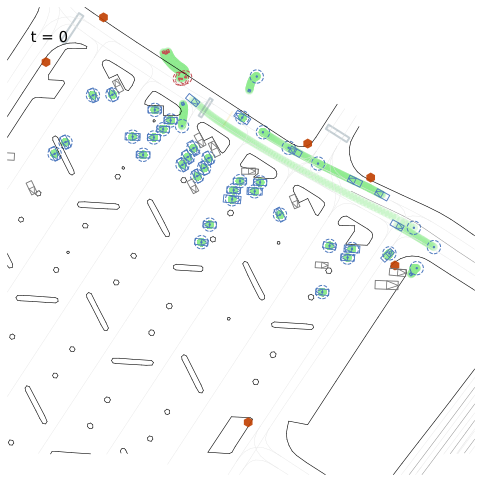

In [13]:
env.vis.figsize = (8, 8)

# Plot simulator state with the stacked trajectories
_ = env.reset()
img = env.vis.plot_simulator_state(
    env_indices=[1], 
    #agent_positions=trajs['agent_positions'],  # Pass stacked trajectories directly
    zoom_radius=70,
    multiple_rollouts=True,
    line_alpha=0.1,          
    line_width=1.0,     
    #weights=trajs['collision_weights'],     
    #colorbar=True, 
    plot_guidance_pos_xy=True,
)[0]

img